## Import Libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# Parameters
col_indx = 4
data_path = "../../"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat"
out_dir = "./"

## Load MetaD Trajectory for ADP

In [3]:
backbone_selection_101 = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

# load data
prmtopFileName =  data_path + gro_file
trajFiles = [data_path+traj_file]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("selected atom indices:", sel_backbone_101.indices)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

['../../run_ala2_metad_sigma0.3_height1.2_pace500_wrapped.trr']
1
selected atom indices: [ 4  6  8 14 16]
Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms being analyzed: 5
Number of frames being analyzed: 100001


## load phi-psi data and bias from metad sim

In [4]:
if col_indx != -1:
    time, phi, psi, bias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,col_indx), unpack=True)
else:
    # loads the final bias 
    time, phi, psi, bias = np.loadtxt(data_path+"colvar_reweight", usecols=(0,1,2,3), unpack=True)
    bias -= bias.min()

time *= 0.001  # in ns

## plot phi-psi

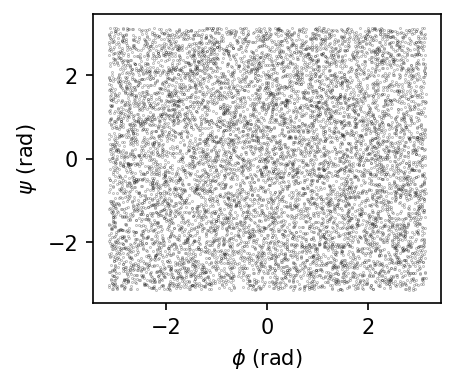

In [5]:
plt.figure(figsize=(3.0,2.5), dpi=150)
plt.xlabel("$\phi$ (rad)")
plt.ylabel("$\psi$ (rad)")
plt.scatter(phi[::10], psi[::10], marker=".", s=0.05, color='k', alpha=1.0)

## plot different choice of metad biases

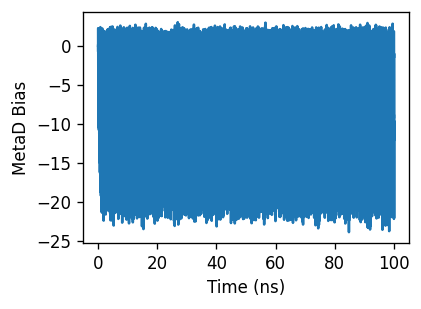

In [6]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("MetaD Bias")
plt.plot(time, bias)

## plot different weights for reweighting

In [7]:
kbt = 0.596161 # in kcal/mol @ 300K

# calculate biases
weights = np.exp(bias/kbt)
weights /= np.sum(weights)

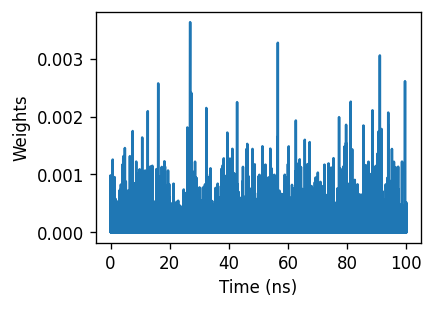

In [8]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights)

## define cluster array

In [9]:
cluster_array = np.arange(1,7,1).astype(int)
print("#clusters :", cluster_array)

#clusters : [1 2 3 4 5 6]


## Perform Cross Validation

In [11]:
train, cv = scripts.cross_validate_cluster_scan\
(trajData, 50000, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 50000
Number of frames to predict each model: 50001
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              20.344           6.665
              1               2               1              54.501          30.859
              1               2               2              53.571          84.649
              1               2               3              52.561         124.092
              1               2               4              42.614         139.006
              1               2               5              52.740         128.373
              1               2               6              52.095         129.411
              1               2               7              53.9

              2               5               7              57.874          52.275
              2               5               8              58.177          53.405
              2               5               9              58.095         288.783
              2               5              10              58.439         273.282
              2               6               1              58.066         281.650
              2               6               2              57.872          58.787
              2               6               3              58.947          71.693
              2               6               4              58.984         301.686
              2               6               5              57.703         275.357
              2               6               6              58.452          78.546
              2               6               7              58.510          65.011
              2               6               8              58.730         

              4               4               6              57.093         221.517
              4               4               7              57.233         172.057
              4               4               8              44.192         197.014
              4               4               9              57.868          59.900
              4               4              10              57.731         219.659
              4               5               1              57.251         154.842
              4               5               2              58.363          83.276
              4               5               3              58.564          85.558
              4               5               4              57.283          50.585
              4               5               5              53.681         242.876
              4               5               6              57.701         259.569
              4               5               7              58.047         

In [13]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

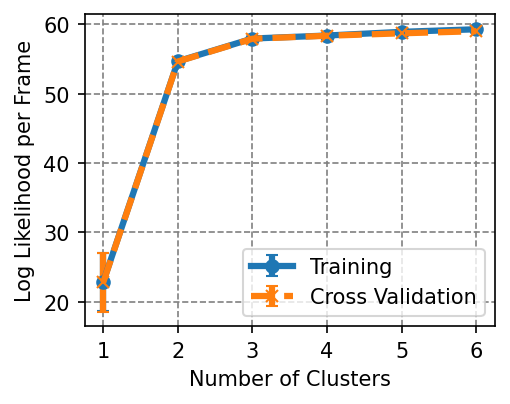

In [14]:
# create figure
plt.figure(figsize=(3.5,2.8), dpi= 150, facecolor='w', edgecolor='k')

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

plt.errorbar(cluster_array,train_mean, train_std, fmt='-o', lw=3, capsize=3, label="Training")

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

plt.errorbar(cluster_array, cv_mean, cv_std, fmt='--x', lw=3, capsize=3, label="Cross Validation")

plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame")
plt.xlabel("Number of Clusters")
plt.tick_params(axis='both')
plt.legend(loc="lower right")
plt.tight_layout()

## n_clusters = 2

In [15]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 2, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              49.329         269.990
       2              53.524         294.360
       3              53.788         284.506
       4              52.804         272.608
       5              53.634         294.372
       6              53.807         287.320
       7              53.664         269.115
       8              54.500          72.693
       9              53.608         269.851
      10              53.664         275.678
      11              53.669         254.891
      12              52.622         295.430
      13              54.478         190.151
      14              40.829         305.677
      15              54.738         251.711
      16              53.707         268.872
      17              52.965         136.514
      18              53.714         274.928
      19       

In [17]:
with open("wsgmm_2state.pickle", "rb") as f:
    wsgmm2 = pickle.load(f)

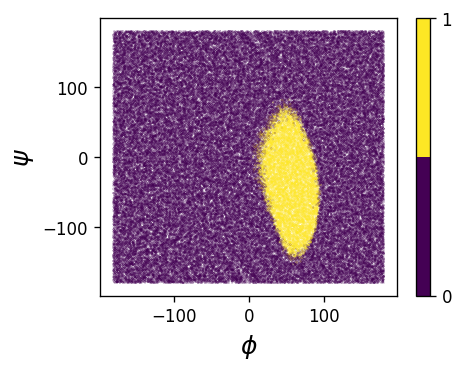

In [18]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm2.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 3

In [10]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              53.114          44.627
       2              53.883          24.775
       3              57.841           9.569
       4              57.537          48.299
       5              57.042          42.448
       6              38.820          50.435
       7              53.785          45.340
       8                 nan          21.520
       9              53.877          40.790
      10              53.467          36.589
      11              47.942          46.496
      12              53.374          44.867
      13              53.466          22.656
      14              54.900           7.661
      15              57.105          27.868
      16              53.470          30.030
      17              57.695          45.502
      18              54.645          45.218
      19       

In [11]:
with open("wsgmm_3state.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [12]:
with open("wsgmm_3state.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

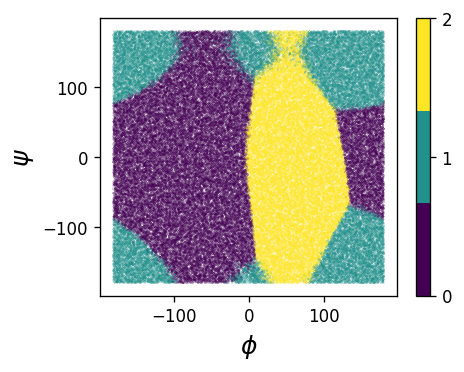

In [13]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm3.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 4

In [14]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              57.989          54.819
       2              57.832          14.063
       3              58.083          58.372
       4              57.160          14.179
       5              57.868          12.899
       6              57.028          53.682
       7              58.047          21.175
       8              57.154          25.924
       9              53.904          28.480
      10              54.497          26.154
      11              57.729          56.230
      12                 nan          10.382
      13              58.160          12.182
      14              53.479          23.422
      15              57.564          11.914
      16              58.143          14.383
      17              51.303          53.949
      18              58.508          16.066
      19       

In [15]:
with open("wsgmm_4state.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [16]:
with open("wsgmm_4state.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

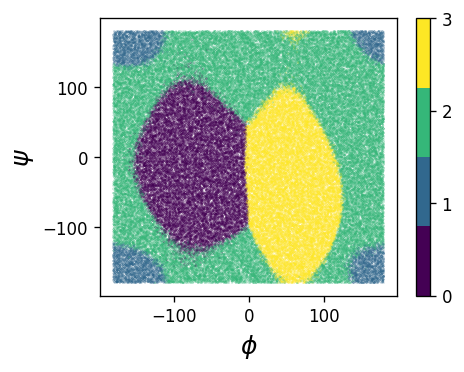

In [17]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm4.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)